In [1]:
!pip install transformers==2.4.0

     |████████████████████████████████| 481kB 8.7MB/s 
     |████████████████████████████████| 3.1MB 20.0MB/s 
     |████████████████████████████████| 890kB 52.7MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ddd7b6d4c8e79684bf94213f0535fe3fd91ea45bca52d5c956ba4c1b44e8c695
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# importing necessary libraries
from typing import List, Tuple
import random
import html

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
import os
from scipy.stats import spearmanr
from scipy.optimize import minimize
from math import floor, ceil
from transformers import *
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [3]:
# fixing random seeds
seed = 13
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# reading the data into dataframe using pandas
train = pd.read_csv('drive/My Drive/case_study_2/train.csv')
test = pd.read_csv('drive/My Drive/case_study_2/test.csv')
submission = pd.read_csv('drive/My Drive/case_study_2/sample_submission.csv')

In [6]:
# # reading the data into dataframe using pandas
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')

In [7]:
# Selecting data for training and testing
y = train[train.columns[11:]] # storing the target values in y
X = train[['question_title', 'question_body', 'answer']]
X_test = test[['question_title', 'question_body', 'answer']]

In [8]:
# Cleaning the data
X.question_body = X.question_body.apply(html.unescape)
X.question_title = X.question_title.apply(html.unescape)
X.answer = X.answer.apply(html.unescape)

X_test.question_body = X_test.question_body.apply(html.unescape)
X_test.question_title = X_test.question_title.apply(html.unescape)
X_test.answer = X_test.answer.apply(html.unescape)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
MAX_SEQUENCE_LENGTH = 512

# this function trims the tokens with length > 512 to match with the bert input.
'''
In the function below, if the input sentence has the number of tokens > 512, the 
sentence is trimmed down to 512. To trim the number of tokens, 256 tokens from 
the start and 256 tokens from the end are kept and the remaining tokens are dropped.
Ex. suppose an answer has 700 tokens, to trim this down to 512, 256 tokens from the
beginning are taken and 256 tokens from the end are taken and concatenated to make 
512 tokens. The remaining [700-(256+256) = 288] tokens that are in the middle of the 
answer are dropped. The logic makes sense because in large texts, the beginning part
usually describes what the text is all about and the end part describes the conclusion
of the text. This is also closely related to the target features that we need to predict.
'''
def _trim_input(question_tokens, answer_tokens, max_sequence_length=512, q_max_len=254, a_max_len=254):
    q_len = len(question_tokens)
    a_len = len(answer_tokens)
    if q_len + a_len + 3 > max_sequence_length:
        if a_max_len <= a_len and q_max_len <= q_len:
            q_new_len_head = q_max_len//2
            question_tokens = question_tokens[:q_new_len_head] + question_tokens[-q_new_len_head:]
            a_new_len_head = a_max_len//2
            answer_tokens = answer_tokens[:a_new_len_head] + answer_tokens[-a_new_len_head:]
        elif q_len <= a_len and q_len < q_max_len:
            a_max_len = a_max_len + (q_max_len - q_len - 1)
            a_new_len_head = a_max_len//2
            answer_tokens = answer_tokens[:a_new_len_head] + answer_tokens[-a_new_len_head:]
        elif a_len < q_len:
            q_max_len = q_max_len + (a_max_len - a_len - 1)
            q_new_len_head = q_max_len//2
            question_tokens = question_tokens[:q_new_len_head] + question_tokens[-q_new_len_head:]

    return question_tokens, answer_tokens

In [10]:
# function for tokenizing the input data for bert
def _convert_to_transformer_inputs(title, question, answer, tokenizer, question_only=False):
    question = f"{title} [SEP] {question}"
    question_tokens = tokenizer.tokenize(question)
    if question_only:
        answer_tokens = []
    else:
        answer_tokens = tokenizer.tokenize(answer)
    question_tokens, answer_tokens = _trim_input(question_tokens, answer_tokens)
    ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + question_tokens + ["[SEP]"] + answer_tokens + ["[SEP]"])
    padded_ids = ids + [tokenizer.pad_token_id] * (MAX_SEQUENCE_LENGTH - len(ids))
    token_type_ids = [0] * (1 + len(question_tokens) + 1) + [1] * (len(answer_tokens) + 1) + [0] * (MAX_SEQUENCE_LENGTH - len(ids))
    attention_mask = [1] * len(ids) + [0] * (MAX_SEQUENCE_LENGTH - len(ids))
    return padded_ids, token_type_ids, attention_mask

In [11]:
# function for creating the input_ids, masks and segments for the bert input
def compute_input_arrays(df, question_only=False):
    input_ids, input_token_type_ids, input_attention_masks = [], [], []
    for title, body, answer in zip(df["question_title"].values, df["question_body"].values, df["answer"].values):
        ids, type_ids, mask = _convert_to_transformer_inputs(title, body, answer, tokenizer, question_only=question_only)
        input_ids.append(ids)
        input_token_type_ids.append(type_ids)
        input_attention_masks.append(mask)
    return (
        np.asarray(input_ids, dtype=np.int32),
        np.asarray(input_attention_masks, dtype=np.int32),
        np.asarray(input_token_type_ids, dtype=np.int32)
    )


def compute_output_arrays(df):
    return np.asarray(df[output_categories])

In [12]:
# Creating the model
K.clear_session()
max_seq_length = 512

input_tokens = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_tokens")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment")

#bert layer
albert_config = AlbertConfig.from_pretrained('albert-base-v2', output_hidden_states=True)
albert_model = TFAlbertModel.from_pretrained('albert-base-v2', config=albert_config)

sequence_output, pooler_output, hidden_states = albert_model([input_tokens,input_mask, input_segment])

# Last 4 hidden layers of bert
h12 = tf.reshape(hidden_states[-1][:,0],(-1,1,768))
h11 = tf.reshape(hidden_states[-2][:,0],(-1,1,768))
h10 = tf.reshape(hidden_states[-3][:,0],(-1,1,768))
h09 = tf.reshape(hidden_states[-4][:,0],(-1,1,768))
concat_hidden = tf.keras.layers.Concatenate(axis=2)([h12, h11, h10, h09])

x = GlobalAveragePooling1D()(concat_hidden)

x = Dropout(0.2)(x)

output = Dense(30, activation='sigmoid')(x)

model_qa = Model(inputs=[input_tokens, input_mask, input_segment], outputs=output)

In [13]:
model_qa.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tokens (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) ((None, 512, 768), ( 11683584    input_tokens[0][0]               
                                                                 input_mask[0][0]             

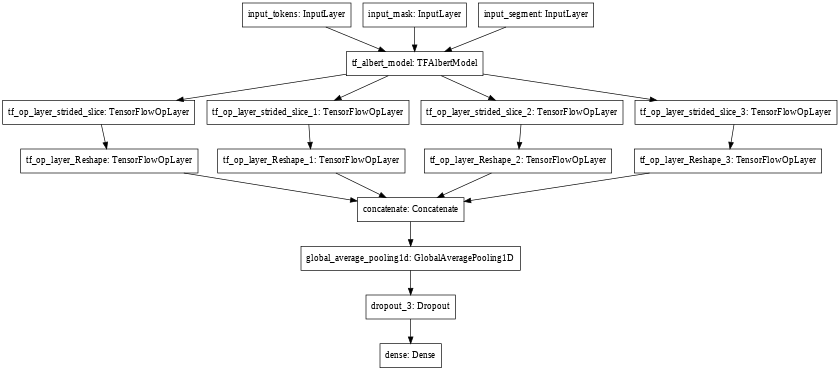

In [14]:
tf.keras.utils.plot_model( 
    model_qa, to_file='model.png', 
    show_shapes=False, 
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=False, dpi=48
)

In [15]:
# test data
tokens, masks, segments = compute_input_arrays(X_test)
test_data = {'input_tokens': tokens, 
             'input_mask': masks, 
             'input_segment': segments} 

In [16]:
# Train data
tokens, masks, segments = compute_input_arrays(X)
def generate_data(tr, cv):
  train_data = {'input_tokens': tokens[tr], 
                'input_mask': masks[tr],
                'input_segment': segments[tr]}

  cv_data = {'input_tokens': tokens[cv], 
             'input_mask': masks[cv],
             'input_segment': segments[cv]}

  return train_data, cv_data, y.values[tr], y.values[cv]

In [17]:
# Function to calculate the Spearman's rank correlation coefficient 'rhos' of actual and predicted data.
from scipy.stats import spearmanr
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

In [18]:
# Making the 'rhos' metric to tensorflow graph compatible.
def rhos(y, y_pred):
  return tf.py_function(compute_spearmanr_ignore_nan, (y, y_pred), tf.double)
metrics = [rhos]

In [19]:
from sklearn.model_selection import KFold
# Compiling and training the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
model_qa.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
kf = KFold(n_splits=5, random_state=42)
for tr, cv in kf.split(np.arange(train.shape[0])):
  tr_data, cv_data, y_tr, y_cv = generate_data(tr, cv)
  model_qa.fit(tr_data, y_tr, epochs=1, batch_size=4, validation_data=(cv_data, y_cv))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


1216/1216 [==============================] - 665s 547ms/step - loss: 0.4046 - rhos: 0.2619 - val_loss: 0.3790 - val_rhos: 0.3680


In [21]:
model_qa.save_weights("drive/My Drive/albert_model_qa.h5")

In [22]:
# train data
tokens, masks, segments = compute_input_arrays(X)
train_data = {'input_tokens': tokens, 
             'input_mask': masks, 
             'input_segment': segments} 

In [23]:
# Predicting the train and test data labels
pred_a_test = model_qa.predict(test_data)
pred_a_train = model_qa.predict(train_data)

# saving the predicted labels as dataframes
df = pd.DataFrame(pred_a_train, columns=y.columns)
df.to_csv('albert_pred_qa_train.csv', index=False)

df = pd.DataFrame(pred_a_test, columns=y.columns)
df.to_csv('albert_pred_qa_test.csv', index=False)